# Autoencoder

We are going to use an autoencoder for task 3

In [ ]:
! pip install livelossplot

In [ ]:
! pip install torcheval

In [ ]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
from torcheval import metrics

# 1. Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = np.load("/content/drive/My Drive/bda/Ferguson_fire_train.npy")

In [ ]:
test = np.load("/content/drive/My Drive/bda/Ferguson_fire_test.npy")

# 2. Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        padding = 1
        output_padding =0


        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding= 2),
            torch.nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.MaxPool2d(2,2),
            torch.nn.LeakyReLU(True),

            torch.nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(True),

        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.LeakyReLU(True),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1, output_padding=0),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=5, stride=1, padding=2, output_padding=output_padding),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1,1,256,256)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
train_tensor = torch.tensor(train, dtype=torch.float32).unsqueeze(1)
val_tensor = torch.tensor(test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_tensor, train_tensor)
val_dataset = TensorDataset(val_tensor, val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    # Initialize PlotLosses
    torch.manual_seed(42)

    liveplot = PlotLosses()

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mse = 0.0
        for data in train_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_mse += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_mse /= len(train_loader.dataset)

        # Validation loss and MSE calculation
        model.eval()
        val_loss = 0.0
        val_mse = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs = data[0].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
                val_mse += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_mse /= len(val_loader.dataset)

        # Check if the current validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Saving new best model at epoch {epoch+1} with validation loss {val_loss:.10f}')

        # Update PlotLosses
        liveplot.update({
            'mse': train_mse,
            'val_mse': val_mse,
            'loss': train_loss,
            'val_loss': val_loss
        })

        liveplot.send()  # Draw, update plots.

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}')
        print(f'Training MSE: {train_mse:.10f}, Validation MSE: {val_mse:.10f}')

    print("Training complete")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAE().to(device)

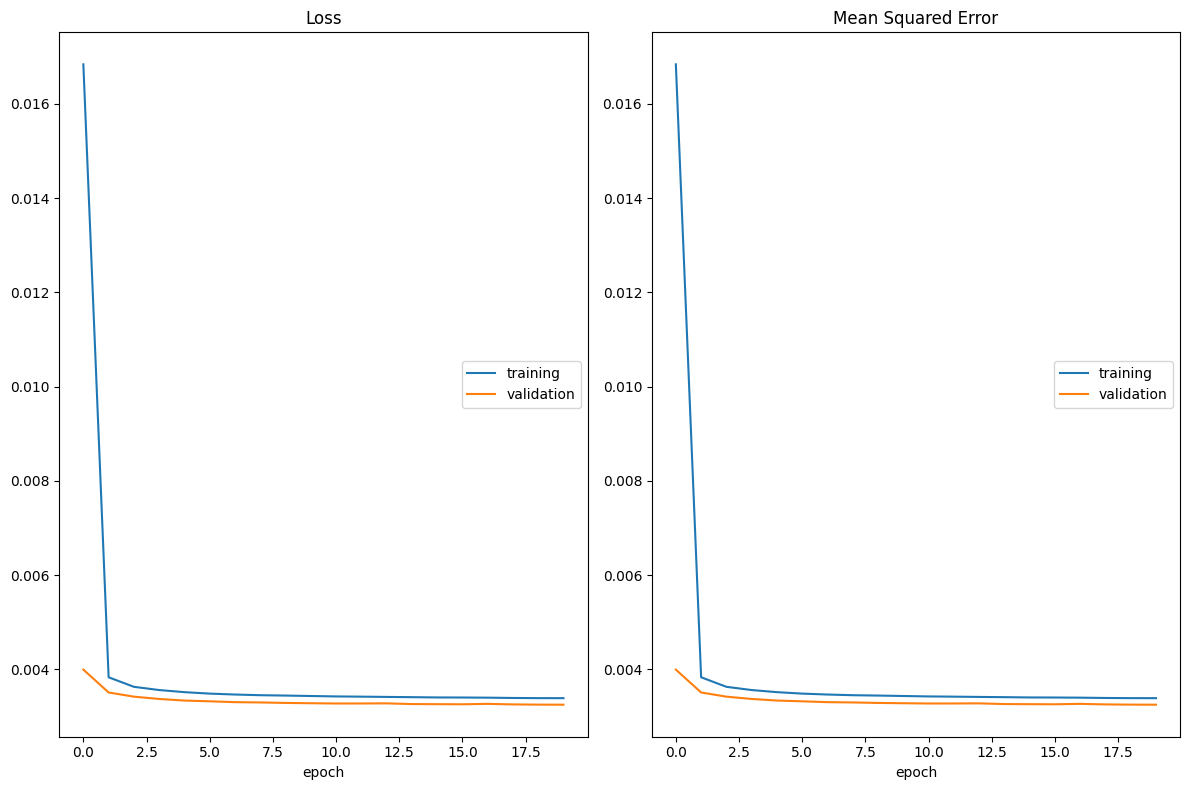

Loss
	training         	 (min:    0.003, max:    0.017, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
Mean Squared Error
	training         	 (min:    0.003, max:    0.017, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)
Epoch [20/20]:
Training Loss: 0.0033893750, Validation Loss: 0.0032503829
Training MSE: 0.0033893750, Validation MSE: 0.0032503829
Training complete


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
save_path = '/content/drive/My Drive/CAEGroup.pth'
train_autoencoder(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

In [ ]:
model.eval()

train_tensor = torch.tensor(train, dtype=torch.float32).unsqueeze(1).to(device)

batch_size = 32
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)

reconstructed_batches = []

with torch.no_grad():
    for batch in train_loader:
        reconstructed_batch = model(batch)
        reconstructed_batches.append(reconstructed_batch.cpu().numpy())

train_recovered = np.concatenate(reconstructed_batches, axis=0)

train_recovered_reshaped = np.reshape(train_recovered, train.shape)

In [ ]:
train_1D = train.reshape(train.shape[0], -1)

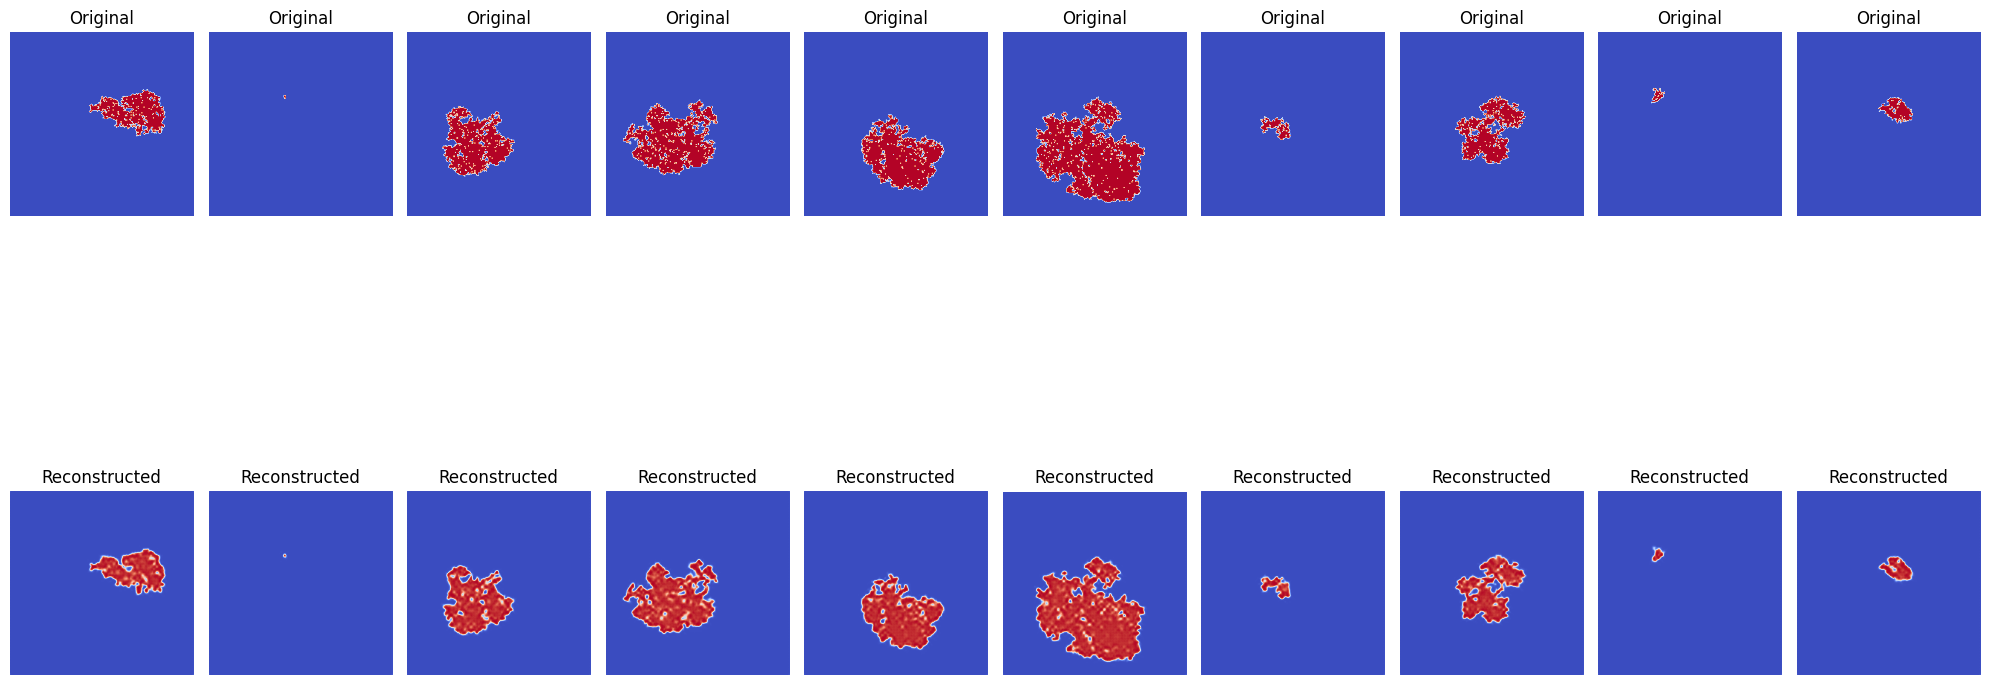

In [ ]:
plt.figure(figsize=(20, 12))

np.random.seed(42)
nDisplay = 10
randomIndex = np.random.randint(0, train_1D.shape[0], nDisplay)

for i in range(nDisplay):
    plt.subplot(2, nDisplay, i + 1)
    plt.imshow(np.reshape(train_1D[randomIndex[i]], (256, 256)), cmap='coolwarm')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(2, nDisplay, i + 1 + nDisplay)
    plt.imshow(np.reshape(train_recovered_reshaped[randomIndex[i]], (256, 256)), cmap='coolwarm')
    plt.axis('off')
    plt.title('Reconstructed')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print('mse: ',mean_squared_error(np.ravel(train),train_recovered.ravel()))

mse:  0.0033863727


In [ ]:
test_1D = test.reshape(test.shape[0], -1)

In [ ]:
model.eval()

test_tensor = torch.tensor(test, dtype=torch.float32).unsqueeze(1).to(device)

batch_size = 32
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

reconstructed_batches = []

with torch.no_grad():
    for batch in test_loader:
        reconstructed_batch = model(batch)
        reconstructed_batches.append(reconstructed_batch.cpu().numpy())

test_recovered = np.concatenate(reconstructed_batches, axis=0)

test_recovered_reshaped = np.reshape(test_recovered, test.shape)

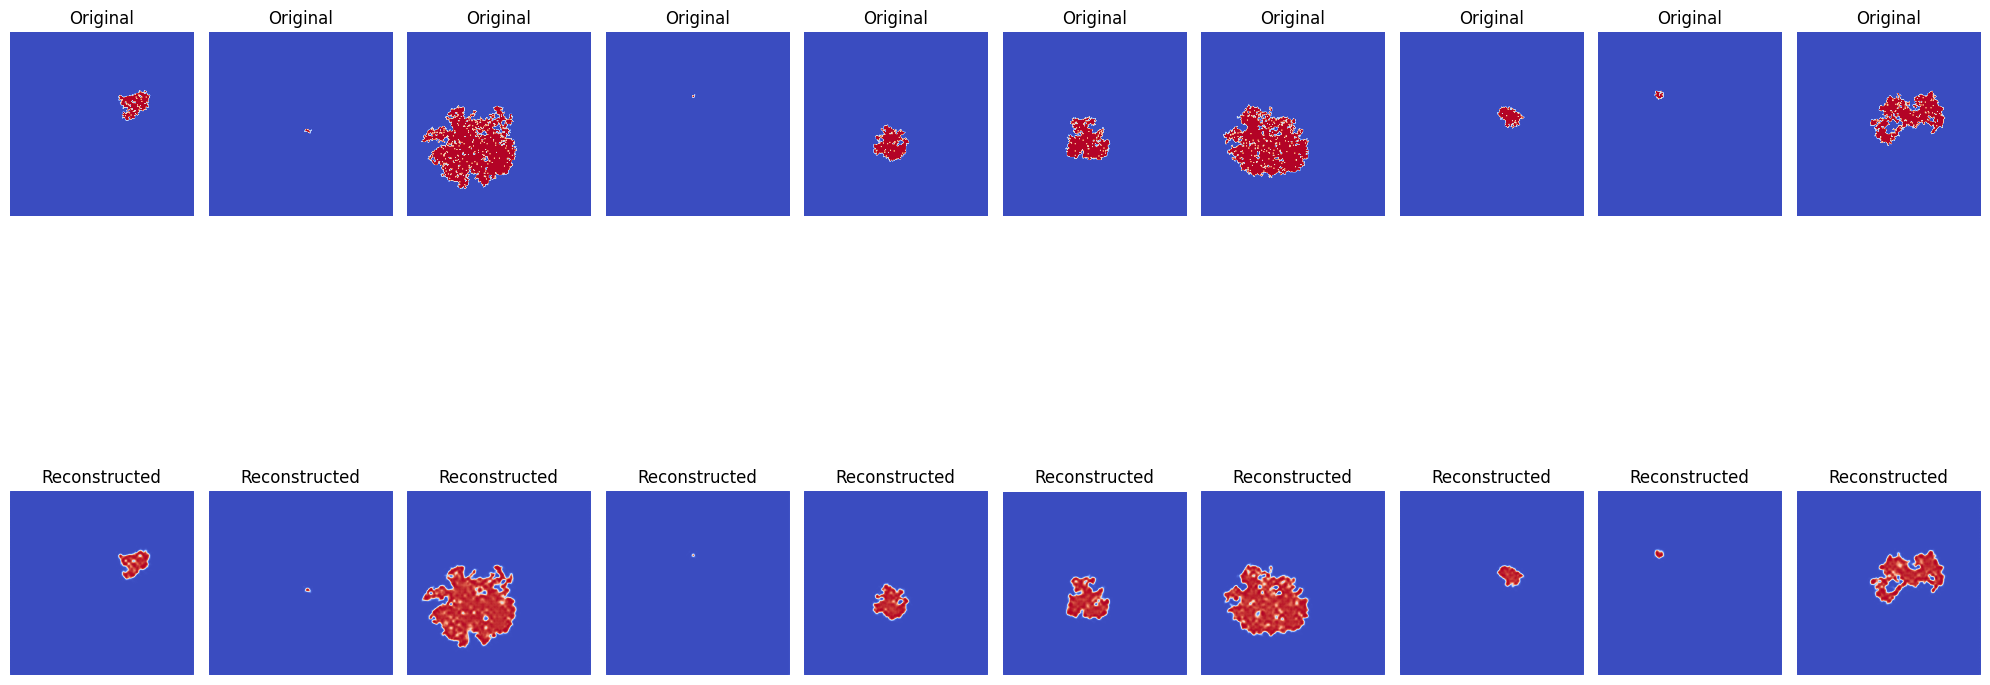

In [ ]:
plt.figure(figsize=(20, 12))

np.random.seed(42)
nDisplay = 10
randomIndex = np.random.randint(0, test_1D.shape[0], nDisplay)

for i in range(nDisplay):
    plt.subplot(2, nDisplay, i + 1)
    plt.imshow(np.reshape(test_1D[randomIndex[i]], (256, 256)), cmap='coolwarm')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(2, nDisplay, i + 1 + nDisplay)
    plt.imshow(np.reshape(test_recovered_reshaped[randomIndex[i]], (256, 256)), cmap='coolwarm')
    plt.axis('off')
    plt.title('Reconstructed')

plt.tight_layout()
plt.show()

In [ ]:
print('mse: ',mean_squared_error(np.ravel(test),test_recovered.ravel()))

mse:  0.0032501637
